# Binh and Korn function
---
**Description**:

- Optimization (min)
- Multi-objective (2)
- Constraints (2)
---

The equations are given by:

\begin{cases}
      f_{1}\left(x,y\right) = 4x^{2} + 4y^{2} \\
      f_{2}\left(x,y\right) = \left(x - 5\right)^{2} + \left(y - 5\right)^{2} \\
\end{cases}

subject to:

\begin{cases}
      C_{1}\left(x,y\right) = \left(x - 5\right)^{2} + y^{2} \leq 25, \\
      C_{2}\left(x,y\right) = \left(x - 8\right)^{2} + \left(y + 3\right)^{2} \geq 7.7 \\
\end{cases}

where:

\begin{cases}
      -15\le x \le 30, \\
      -15\le y \le 30. \\
\end{cases}

The Pareto-optimal solutions are constituted by solutions:
$ x=y ∈ [0.0, 3.0] \text{  and  } x ∈ [3.0, 5.0], y=3.0.$

## Step 1: Import python libraries and set up the project directory

In [1]:
import os, sys
import numpy as np
from functools import lru_cache
from matplotlib import pyplot as plt

PROJECT_DIR = os.path.abspath('..')

if PROJECT_DIR not in sys.path:
    sys.path.append(PROJECT_DIR)

## Step 2: Import the custom PSO code

In [2]:
from star_pso.population.swarm import Swarm
from star_pso.population.particle import Particle
from star_pso.engines.standard_pso import StandardPSO
from star_pso.utils.auxiliary import pareto_front, cost_function

## Step 3: Define the multi-objective function

In [3]:
# Auxiliary method that returns a random value in [0, 1].
@lru_cache(maxsize=1024)
def random_weight(i: int = 0) -> float:
    return np.random.random()

# Multi-objective cost function.
@cost_function(minimize=True)
def fun_binh_korn(vector_xy: np.ndarray, **kwargs) -> float:
    
    # Set the penalty coefficient.
    rho = 5.0
        
    # Extract the values from the particle position.
    x, y = vector_xy
        
    # Compute each objective function.
    f1 = 4.0 * (x**2 + y**2)
    f2 = (x - 5.0)**2 + (y - 5.0)**2
        
    # Compute the constraints.
    C1 = max(0.0, (x - 5.0)**2 + y**2 - 25.0)**2
    C2 = min(0.0, (x - 8.0)**2 + (y + 3.0)**2 - 7.7)**2
    
    # Assign the weights.
    w1 = random_weight(kwargs["it"])
    w2 = 1.0 - w1
        
    # Compute the final value.
    f_value = w1*f1 + w2*f2 + rho*(C1 + C2)
    
    # Return the solution.
    return f_value
# _end_def_

## Step 4: Set the PSO parameters

    - Number of particles 'N'
    - Initial population
    - PSO object

In [4]:
# Set a seed for reproducible initial population.
SEED = 1821

# Random number generator.
rng = np.random.default_rng(SEED)

# Define the number of optimizing variables.
D = 2

# Define the number of particles.
N = 100

# Draw random samples for the initial points.
X_t0 = rng.uniform(-15.0, 30.0, size=(N, D))

# Initial population.
swarm_t0 = Swarm([Particle(x) for x in X_t0])

# Create a StandardPSO object that will perform the optimization.
test_PSO = StandardPSO(initial_swarm = swarm_t0,
                       obj_func = fun_binh_korn,
                       x_min = -15.0, x_max = 30.0)

## Step 5: Run the optimization process

In [5]:
test_PSO.run(max_it = 1500,
             options = {"w0": 0.70, "c1": 1.50, "c2": 1.50, "mode": "g_best"},
             reset_swarm = False, verbose = False, adapt_params = False)

12/18/2025 09:44:22 INFO: Initial f_optimal = -13.5449


Final f_optimal = -20.1518
run: elapsed time = 17.651 seconds.


## Step 6: Extract the data for analysis and plotting

In [6]:
# Get the optimal solution from the PSO.
_, _, z_opt = test_PSO.get_optimal_values()

# Extract the optimal optimization variables.
x, y = z_opt

# Compute the final objective functions.
f1_opt = 4.0 * (x**2 + y**2)
f2_opt = (x - 5.0)**2 + (y - 5.0)**2

# Print the results.
print(f"x={x:.5f}, y={y:.5f}", end='\n\n')
print(f"f1(x, y) = {f1_opt:.5f}")
print(f"f2(x, y) = {f2_opt:.5f}")

x=0.10772, y=-0.07383

f1(x, y) = 0.06822
f2(x, y) = 49.67822


### If requested extract other solutions

In [7]:
best_n = []

for p in test_PSO.swarm.best_n(N//2):
    # Extract the position.
    x_p, y_p = p.best_position

    # Compute the final objective functions.
    best_n.append((4.0*(x_p**2 + y_p**2),
                  (x_p - 5.0)**2 + (y_p - 5.0)**2))
    
# Convert to numpy.
best_n = np.array(best_n)

### Compute the Pareto front

In [8]:
# Create a list that will hold points that satisfy both constraints.
points = []

# Generate a 2D grid sample on [-15.0, 30].
for x in np.linspace(-15.0, 30.0, 100):
    
    for y in np.linspace(-15.0, 30.0, 100):
    
        # Compute the constraints.
        C1 = (x - 5.0)**2 + y**2 <= 25.0
        C2 = (x - 8.0)**2 + (y + 3.0)**2 >= 7.7

        # If both constraints are satisfied.
        if C1 and C2:

            # Evaluate both functions.
            f1 = 4.0 * (x**2 + y**2)
            f2 = (x - 5.0)**2 + (y - 5.0)**2

            # Keep the point in the list.
            points.append((f1, f2))
        # _end_if_
    # _end_for_
# _end_for_

# Convert lists to numpy.
points = np.array(points)

# Estimate the pareto front points.
pareto_points = pareto_front(points)

### Visualize the solution on the Pareto plot

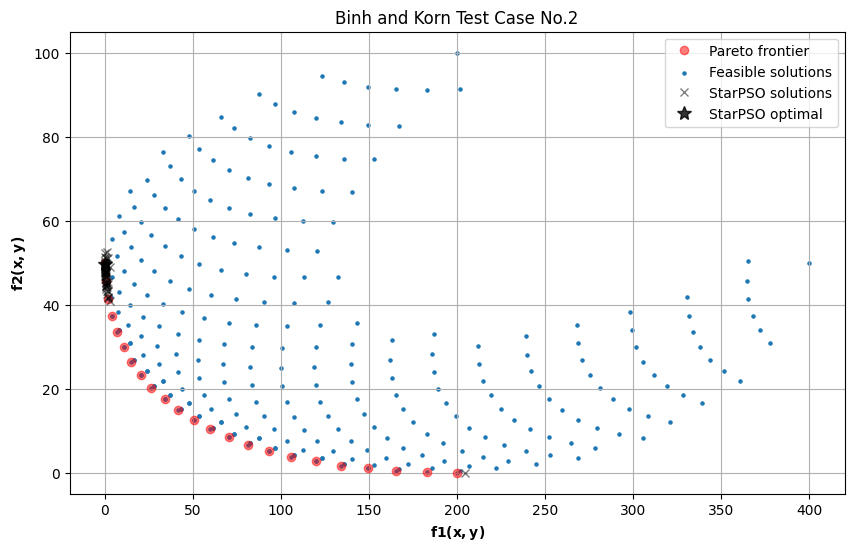

In [9]:
# Create a new figure.
plt.figure(figsize=(10, 6))

# Plot the Pareto front.
plt.plot(pareto_points[:, 0],
         pareto_points[:, 1],
         'ro', alpha=0.5, label="Pareto frontier")

# Plot all the feasible solutions.
plt.scatter(x=points[:, 0],
            y=points[:, 1],
            s=5, marker='o', label="Feasible solutions")

# Plot other points.
plt.plot(best_n[:, 0],
         best_n[:, 1],
         'kx', alpha=0.5, label="StarPSO solutions")

# Plot the optimal solution from the PSO.
plt.plot(f1_opt, f2_opt,
         'k*', markersize=10, alpha=0.8, label="StarPSO optimal")

# Tidy up the plot.
plt.title("Binh and Korn Test Case No.2")
plt.xlabel(r"$\mathbf{f1(x,y)}$")
plt.ylabel(r"$\mathbf{f2(x,y)}$")
plt.legend()
plt.grid(True)

plt.savefig("Binh_and_Korn_optimal.pdf", format="pdf", dpi=300)

### End of file